<a href="https://colab.research.google.com/github/purvi0116/CS251/blob/master/pear_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing and Importing some required packages



In [ ]:
! pip install Pillow==5.3.0

In [ ]:
import torch 
import time 
import copy
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms , models, datasets
import PIL
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import timeit

Import drive to colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


Data loading and preprocessing

In [ ]:
train_dir = 'gdrive/My Drive/pearFinal/datasetFinal/train'
test_dir = 'gdrive/My Drive/pearFinal/datasetFinal/test'
valid_dir = 'gdrive/My Drive/pearFinal/datasetFinal/valid'
dirs = {'train': train_dir,
        'test': test_dir,
        'validation':valid_dir
        }

In [ ]:
# add transforms to the data
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((256,256)),                       
        transforms.ToTensor()
    ]),
    'validation' : transforms.Compose([
        transforms.Resize((256,256)),                       
        transforms.ToTensor()
    ]),
    'test' : transforms.Compose([
        transforms.Resize((256,256)),                       
        transforms.ToTensor()
    ])
}    

In [ ]:
#number of samples per batch to load
batch_size = 6

In [ ]:
image_datasets = {x:datasets.ImageFolder(dirs[x],  transform = data_transforms[x]) for x in ['train',  'validation','test']}
#load the data into batches
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(image_datasets['validation'], batch_size=batch_size,shuffle=True)
num_train = len(image_datasets['train'])
num_valid = len(image_datasets['validation'])
num_test = len(image_datasets['test'])

In [ ]:
print(num_train,num_valid,num_test)

470 40 63


In [ ]:
classes = image_datasets['train'].classes
print(classes)

['bruised', 'good', 'worst']


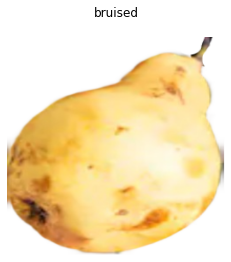

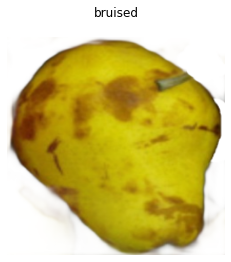

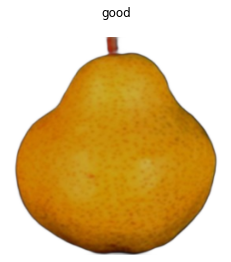

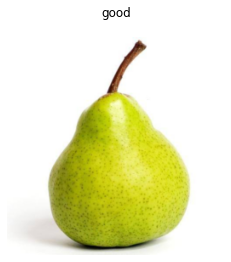

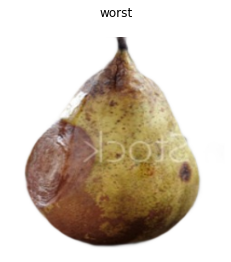

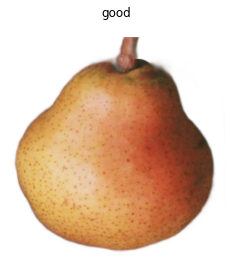

In [ ]:
def imshow(image,title = '',caption = ''):
  if isinstance(image, torch.Tensor):
    image = image.numpy().transpose((1,2,0))
  else :
    image = np.array(image).transpose((1,2,0))

    #unnormalize
  mean = np.array([0.5317, 0.5194, 0.3677])
  std = np.array([0.1899, 0.1937, 0.2299])
  #image = std * image + mean
  image = np.clip(image, 0, 1)
  # Plot
  fig, ax = plt.subplots(1, 1, figsize = (4, 4))
  plt.imshow(image)
  ax.axis('off')
  plt.title(title + '\n' + caption)

images,imgclass = next(iter(test_loader)) 
for image,imclass in zip(images,imgclass):
  out = torchvision.utils.make_grid(image, nrow = 8)
  imshow(out,classes[imclass]) 

In [ ]:
def reset(m):
  if hasattr(m,'reset_parameters'):
    m.reset_parameters()

In [ ]:
def flatten(x):
  N= x.shape[0]
  return x.view(N,-1)

class Flatten(nn.Module):
  def forward(self,x):
    return flatten(x)

In [ ]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cuda


In [ ]:
# Constant to control how frequently we print train loss
print_every = 40

In [ ]:
def plot_graph(valid_acc,train_acc,num_epochs):
  epoch_range=list(range(1,num_epochs+1))
   
  plt.plot(epoch_range,valid_acc,label='validation acc')
  plt.plot(epoch_range,train_acc,label='train acc')
  #plt.ylim(70,105)
  plt.legend()
  plt.show()

In [ ]:
def plot_loss(cost,num_loop):
  loop_range=list(range(1,num_loop+1))
  plt.plot(loop_range,cost,label='loss function')
  
  plt.legend()
  plt.show()

In [ ]:
def wrong_pred(scores, y, preds,x_var ,batch_size,plot):# scoeres = scores.data.cpu()
  for i in range(batch_size):
    #if predicted score for ith example in mini-batch of 4 is wrong draw image 
    #and print the scores
    if plot:
      percent=scoresToPercent(torch.tensor(scores[i].cpu()))
      label_ = 'correct :'+classes[y[i]]+" " +str(round(float(percent[y[i]]),4)) + '\n predicted :'+classes[preds[i]]+ " "+str(percent[preds[i]])
      imshow(x_var[i].cpu(),label_)

    elif preds[i]!=y[i]:
      percent=scoresToPercent(torch.tensor(scores[i].cpu()))
      label_ = 'correct :'+classes[y[i]]+" " +str(round(float(percent[y[i]]),4)) + '\n predicted :'+classes[preds[i]]+ " "+str(percent[preds[i]])
      imshow(x_var[i].cpu(),label_)

In [ ]:
def scoresToPercent(scores):
  percent=(torch.nn.functional.softmax(scores))
  
  return(percent*100)

In [ ]:
def check_accuracy(loader, model,show_wrong=False):
    plot=False
    if loader==valid_loader:
        print('Checking accuracy on validation set')
        plot=True

    elif loader==test_loader:
        print('Checking accuracy on test set')   
        plot=True
    else:
        print('Checking accuracy on train set')    
        plot = True
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            batch_size=len(y)
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
          
            _, preds = scores.max(1)
            
            if(show_wrong):
              wrong_pred(scores,y,preds,x, batch_size,plot)
              

            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return (100*acc)

In [ ]:
def train(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    best_acc=0
    best_model=None
    valid_acc=[]  # for plot
    train_acc=[]   # for plot
    cost = []
    iteration = 0 
    loss_iter=0
    for e in range(epochs):
        print('Epoch :',e)
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            loss_iter+=1
            cost.append(loss)
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy(valid_loader, model)
                valid_acc.append(acc)
                train_acc.append(check_accuracy(train_loader, model))
                iteration+=1
                if acc>=best_acc:
                  best_acc = acc
                  best_model = copy.deepcopy(model) 
                print()
    plot_graph(valid_acc,train_acc,iteration) 
    plot_loss(cost,loss_iter)   
    print(loss_iter,'total iterations')       
    return(best_model,best_acc)

**The** **Model**

In [ ]:
model3 = nn.Sequential(
       nn.Conv2d(in_channels =3,out_channels=32,kernel_size=5,stride=1,padding=0), #kernelsize=3
       nn.PReLU(),
       nn.BatchNorm2d(32),
       nn.MaxPool2d(kernel_size=2, stride = 2),
       
       nn.Conv2d(32,64,3,1),
       nn.PReLU(),
       nn.MaxPool2d(kernel_size=2, stride = 2),

       nn.Conv2d(64,128,3,1,),
       nn.PReLU(),
       nn.BatchNorm2d(128),
       nn.MaxPool2d(kernel_size=2, stride = 2),
       
       nn.Conv2d(128,128,3,1,padding=1),
       nn.PReLU(),
       nn.MaxPool2d(kernel_size=2, stride = 2),

       nn.Conv2d(128,64,3,1),
       nn.PReLU(),
       nn.BatchNorm2d(64),
       nn.MaxPool2d(kernel_size=2, stride = 2),
       
       Flatten(),
       nn.Linear(2304,1024),
       nn.ReLU(),
       nn.Dropout2d(p=0.5),  
       nn.Linear(1024,512),
       nn.ReLU(),
       nn.Dropout2d(p=0.5),
       nn.Linear(512,3)
)


Streaming output truncated to the last 5000 lines.
Checking accuracy on train set
Got 385 / 470 correct (81.91)

Iteration 40, loss = 0.5887
Checking accuracy on validation set
Got 29 / 40 correct (72.50)
Checking accuracy on train set
Got 386 / 470 correct (82.13)

Epoch : 116
Iteration 0, loss = 1.0556
Checking accuracy on validation set
Got 29 / 40 correct (72.50)
Checking accuracy on train set
Got 388 / 470 correct (82.55)

Iteration 40, loss = 0.7235
Checking accuracy on validation set
Got 29 / 40 correct (72.50)
Checking accuracy on train set
Got 388 / 470 correct (82.55)

Epoch : 117
Iteration 0, loss = 0.2138
Checking accuracy on validation set
Got 29 / 40 correct (72.50)
Checking accuracy on train set
Got 386 / 470 correct (82.13)

Iteration 40, loss = 0.2093
Checking accuracy on validation set
Got 28 / 40 correct (70.00)
Checking accuracy on train set
Got 390 / 470 correct (82.98)

Epoch : 118
Iteration 0, loss = 0.3860
Checking accuracy on validation set
Got 30 / 40 correct 

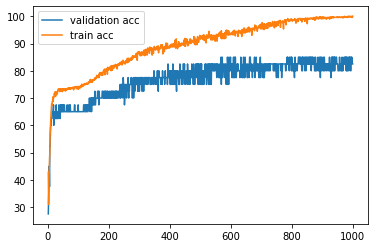

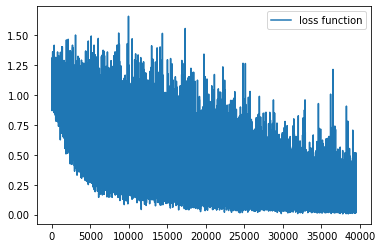

39500 total iterations
minutes took 102.7519168694814
hours took 1.71253194782469


In [ ]:
model3.cuda()
optimizer = optim.Adam(model3.parameters(), lr = 0.5e-6 ,weight_decay = 0.1)
t1 = time.time()
best_model,best_acc=train(model3,optimizer,500)
t2 = time.time()
print("minutes took",(t2-t1)/60)
print("hours took",(t2-t1)/(60*60))

In [ ]:
PATH = 'gdrive/My Drive/pearFinal/BestModel1.pt'
torch.save(best_model.state_dict(), PATH)

In [ ]:
print(best_acc)

85.0


Epoch : 0
Iteration 0, loss = 0.3012
Checking accuracy on validation set
Got 32 / 40 correct (80.00)
Checking accuracy on train set
Got 469 / 470 correct (99.79)

Iteration 40, loss = 0.1686
Checking accuracy on validation set
Got 33 / 40 correct (82.50)
Checking accuracy on train set
Got 469 / 470 correct (99.79)

Epoch : 1
Iteration 0, loss = 0.0859
Checking accuracy on validation set
Got 34 / 40 correct (85.00)
Checking accuracy on train set
Got 470 / 470 correct (100.00)

Iteration 40, loss = 0.1166
Checking accuracy on validation set
Got 32 / 40 correct (80.00)
Checking accuracy on train set
Got 469 / 470 correct (99.79)

Epoch : 2
Iteration 0, loss = 0.1164
Checking accuracy on validation set
Got 34 / 40 correct (85.00)
Checking accuracy on train set
Got 468 / 470 correct (99.57)

Iteration 40, loss = 0.0396
Checking accuracy on validation set
Got 33 / 40 correct (82.50)
Checking accuracy on train set
Got 470 / 470 correct (100.00)

Epoch : 3
Iteration 0, loss = 0.1616
Checking a

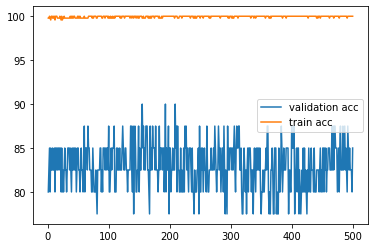

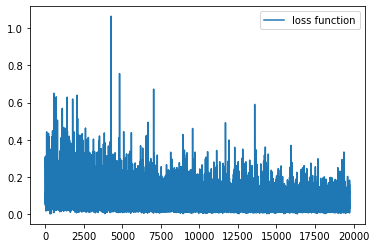

19750 total iterations
minutes took 51.2135910987854
hours took 0.8535598516464233


In [ ]:
optimizer = optim.Adam(model3.parameters(), lr = 0.5e-6 ,weight_decay = 0.1)
t1 = time.time()
best_model,best_acc=train(model3,optimizer,250)
t2 = time.time()
print("minutes took",(t2-t1)/60)
print("hours took",(t2-t1)/(60*60))

In [ ]:
print(best_acc)

90.0


In [ ]:
PATH = 'gdrive/My Drive/pearFinal/bestmodel2.pt'
torch.save(best_model.state_dict(), PATH)

In [ ]:
input_tensor=torch.rand(1,3,256,256)
model.to("cpu")
script_model=torch.jit.trace(best_model,input_tensor)
script_model.save("gdrive/My Drive/PearScriptCustom.pt")

**FINAL RESULTS ON TEST SET**

Checking accuracy on test set


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Got 42 / 58 correct (72.41)


72.41379310344827

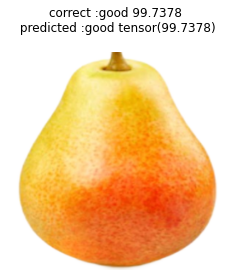

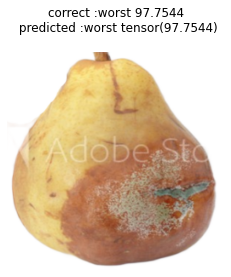

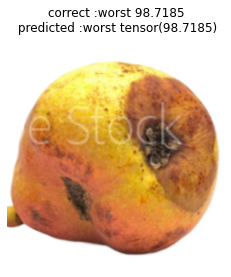

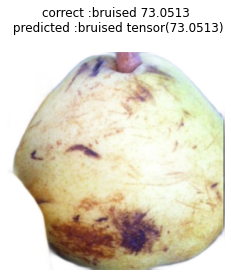

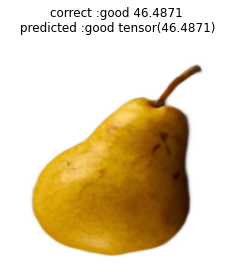

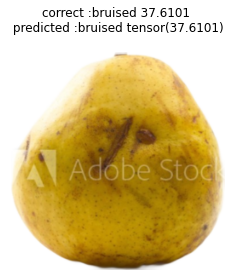

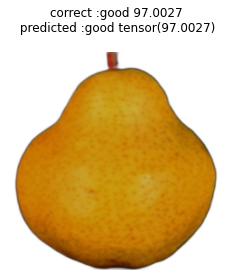

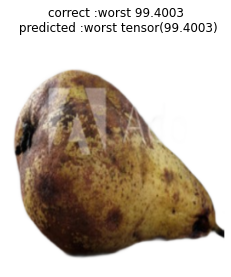

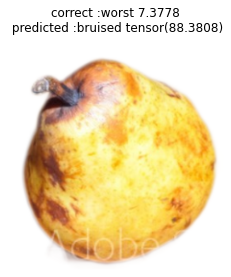

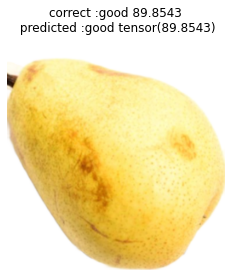

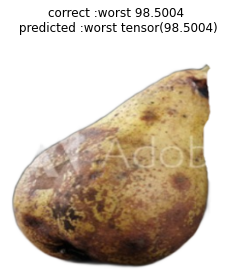

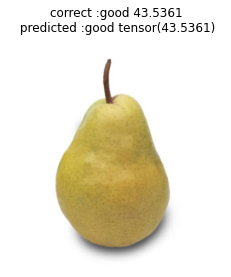

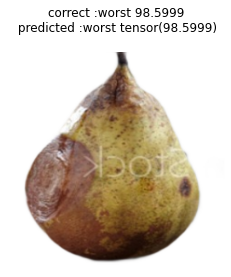

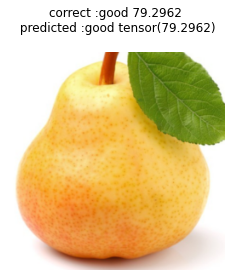

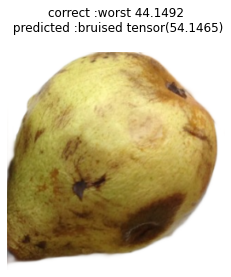

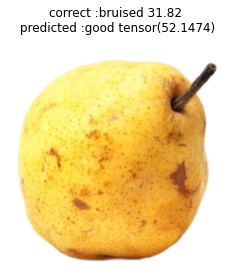

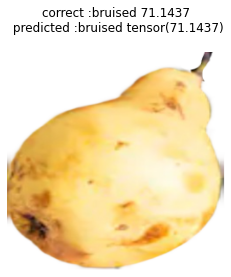

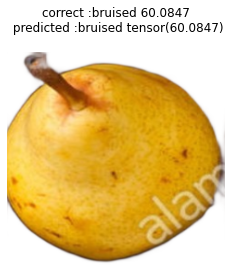

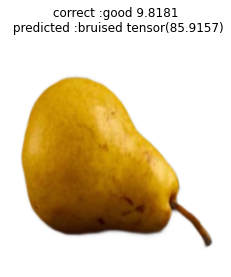

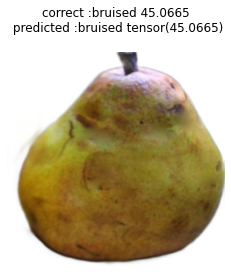

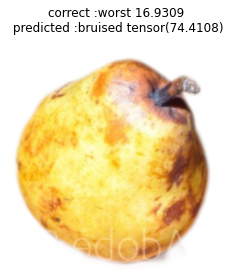

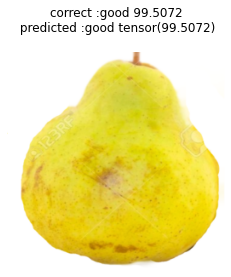

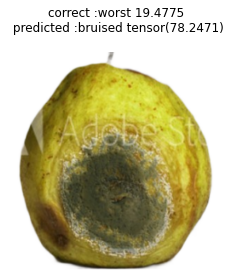

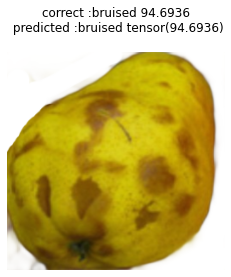

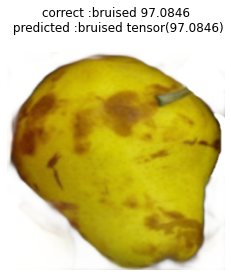

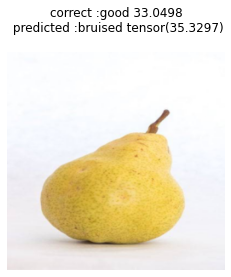

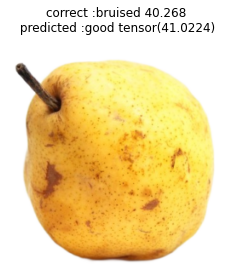

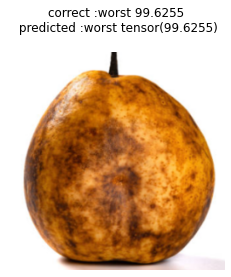

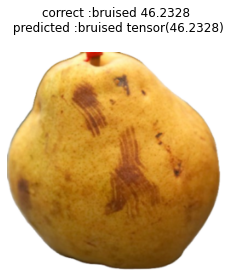

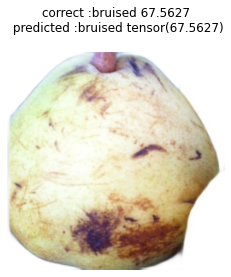

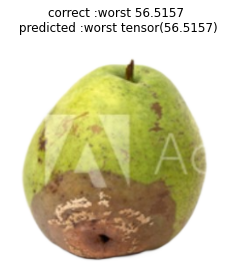

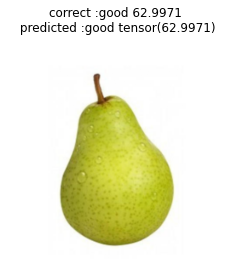

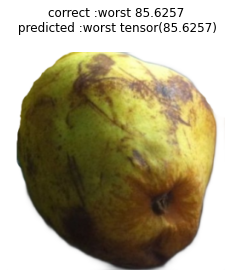

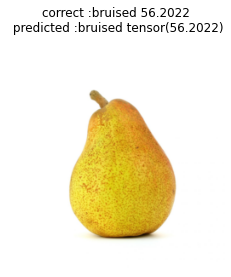

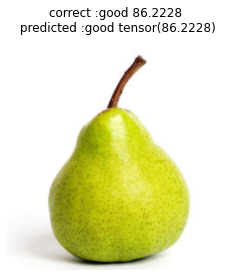

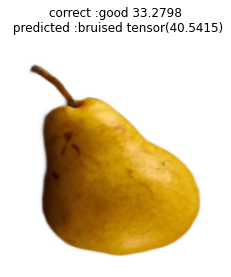

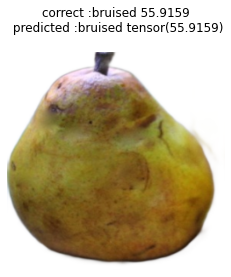

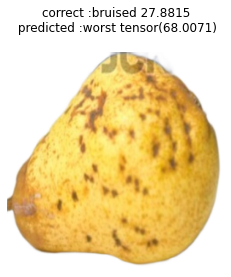

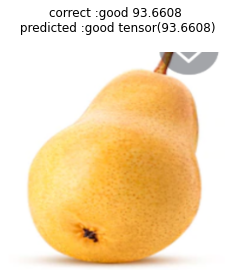

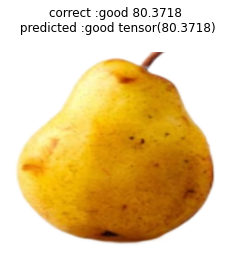

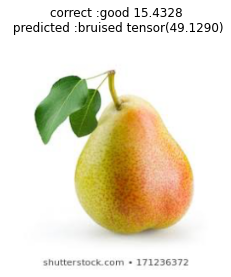

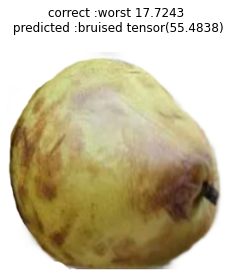

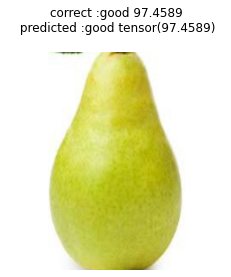

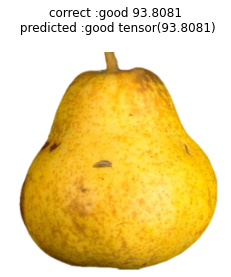

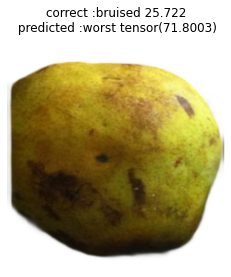

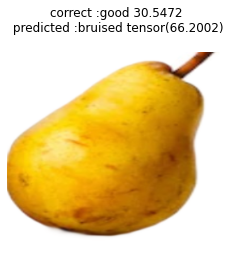

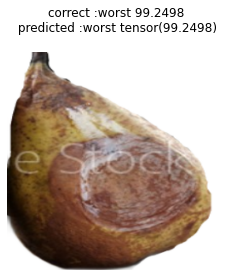

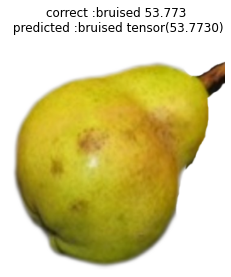

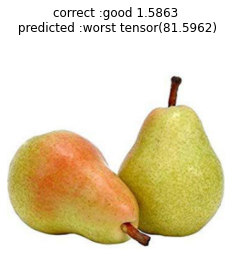

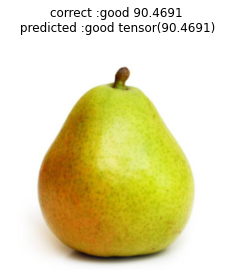

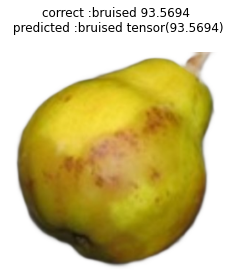

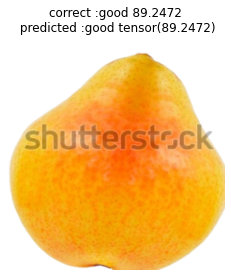

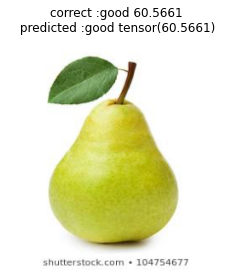

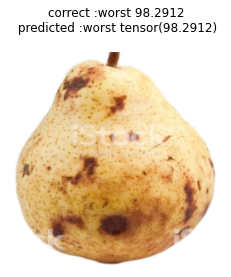

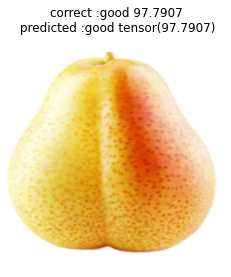

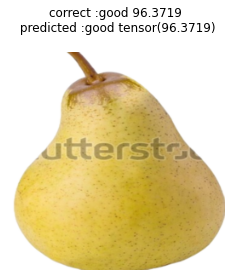

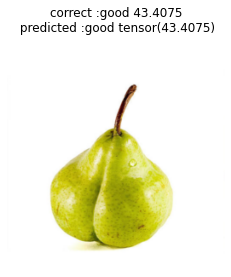

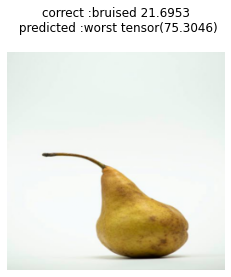

In [ ]:
PATH = "gdrive/My Drive/pearFinal/bestmodel2.pt"
model=model3.type(dtype)
model.load_state_dict(torch.load(PATH))
model.cuda()

check_accuracy(test_loader, model, True)